In [1]:
# import sys
# !{sys.executable} -m pip install -r requirements.txt

In [2]:
from nltk import word_tokenize
import pandas as pd
import numpy as np
from datasets import load_dataset
from SimilarityHelpers import get_cos_similarity_score
from sentence_transformers import SentenceTransformer
embedder = SentenceTransformer('all-MiniLM-L6-v2')
import matplotlib.pyplot as plt

In [3]:
# Download the parquet data from Huggingface
samsum = load_dataset("Samsung/samsum", revision="refs/convert/parquet", data_files={"test": "samsum/test/0000.parquet"})["test"]
webis = load_dataset("webis/tldr-17", revision="refs/convert/parquet", data_files={"default": "default/partial-train/0000.parquet"})["default"]

In [5]:
# Take a random 10% of Webis
webis_sel = webis.shuffle(seed=42).train_test_split(test_size=0.1)
webis_test = webis_sel['test']

In [6]:
# Try taking cosine similarity on the provided summaries and original content/dialogue
def samsum_cos_sim(example):
    a = example['dialogue']
    b = example['summary']
    ax = embedder.encode(np.array([a]), convert_to_tensor=True)
    bx = embedder.encode(np.array([b]), convert_to_tensor=True)
    return {'cos_sim': get_cos_similarity_score(ax, bx)}

def webis_cos_sim(example):
    a = example['content']
    b = example['summary']
    ax = embedder.encode(np.array([a]), convert_to_tensor=True)
    bx = embedder.encode(np.array([b]), convert_to_tensor=True)
    return {'cos_sim': get_cos_similarity_score(ax, bx)}

In [7]:
w_test = webis_test.map(webis_cos_sim).to_pandas()
s_test = samsum.map(samsum_cos_sim).to_pandas()

Map:   0%|          | 0/13300 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

In [63]:
w_test.cos_sim.max()

0.9398948550224304

In [64]:
s_test.cos_sim.max()

0.9129816293716431

In [29]:
len(s_test.loc[s_test.cos_sim < 0.5]) / len(s_test)

0.03785103785103785

In [30]:
len(w_test.loc[w_test.cos_sim < 0.5]) / len(w_test)

0.6195488721804512

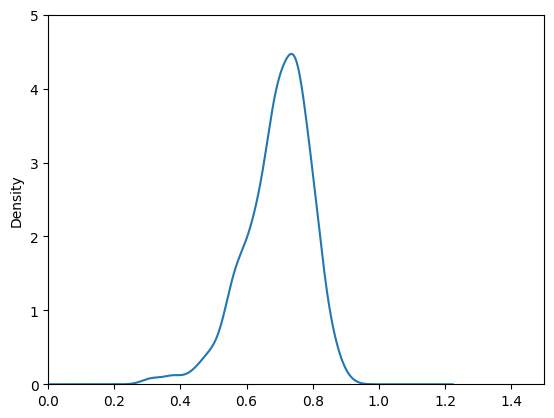

In [57]:
# Peek at cosine similarity density
s_test.cos_sim.plot(kind="kde")
plt.xlim(0, 1.5)
plt.ylim(0, 5)
plt.show()

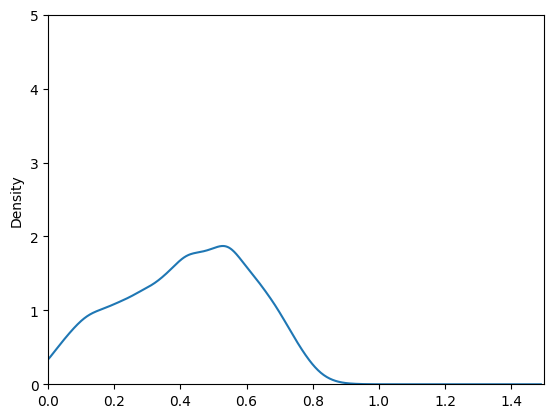

In [60]:
w_test.cos_sim.plot(kind="kde")
plt.xlim(0, 1.5)
plt.ylim(0, 5)
plt.show()

In [61]:
# Take a sample of Webis of similar volume to SAM-Sum
q = w_test.loc[w_test.cos_sim > s_test.cos_sim.min()].sample(n=819, random_state=42)

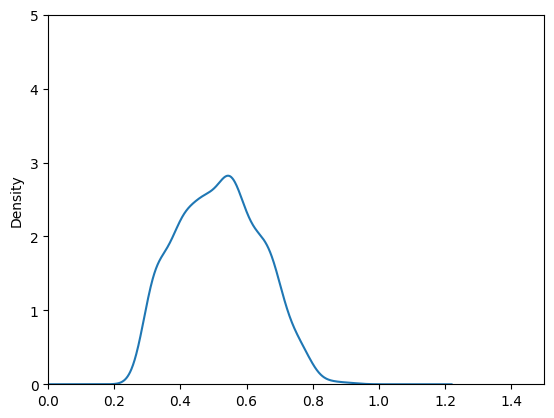

In [62]:
q.cos_sim.plot(kind="kde")
plt.xlim(0, 1.5)
plt.ylim(0, 5)
plt.show()

In [20]:
# aux columns for token counting
s_test["utt_num"] = s_test.dialogue.str.split("\n").apply(len)
s_test["dialogue_length"] = s_test.dialogue.apply(word_tokenize).apply(len)
s_test["summary_length"] = s_test.summary.apply(word_tokenize).apply(len)
w_test["summary_length"] = w_test.summary.apply(word_tokenize).apply(len)
w_test["content_length"] = w_test.content.apply(word_tokenize).apply(len)

In [21]:
samsum_tokens = s_test.dialogue_length.sum() + s_test.summary_length.sum()
print("SAM-Sum: {} tokens".format(samsum_tokens))

SAM-Sum has ~122662 tokens


In [22]:
webis_tokens = w_test.summary_length.sum() + w_test.content_length.sum()
print("Webis: {} tokens".format(webis_tokens))

Webis has ~3478234 tokens
